**NOTE:** this notebook can be a presentation. Just run `nbpresent Lyncs.ipynb` for starting the slide show.

# Introduction and motivations

Lattice QCD is a highly-computationally intensive research field and access the largest supercomputers in the world.

A large variety of LQCD software is available and they differ for several reasons:
- **Field theories**: dimensions, groups (SU(3), SU(N), ...)

- **Fermion discretizations**: Wilson, Twisted Mass, Staggered, Domain Walls, ...

- **Algorithms**: simulations, solvers, contractions, ...

- **Computing Architecture**: CPUs, GPUs, KNLs, NVIDIA, Intel, ARM, ...

- **Programming Language**: C, C++, CUDA, ...

- ***Programming Model***: Kokkos, OpenCL, ...

- **Collaborations**: USQCD, UKQCD, ETMC, BMW, ...


## Towards community codes

In the recent years there is an increasing effort for community codes in Lattice QCD.

A remarkable example is [QUDA](https://github.com/lattice/quda), supported by NVIDIA, which implements
a large variety of highly optimized kernels for GPUs and involves developer all around the world.

Important features of community codes are
- Clean implementation

- Well documented

- Fully tested

- Backwards compatibility

- User-friendly

- Open source

- User support

## Standard LQCD approach

A standard computational approach for LQCD is **Domain Decomposition** (Distributed Data).

This is (*almost*) the only way exploited for scaling on supercomputers.

But recent algorithms and architectures limit significantly the scaling of LQCD calculations.

**Multigrid methods** have been one of the major breaking point. 

<h2>Alternatives</h2>

- **Task parallelism**: Independent tasks are executed at the same time

- **Pipeline parallelism**: Dependent tasks are pipelined and executed in parallel on chunks of data

## Simulations vs Measurements

LQCD calculations usually proceed in two steps

- **Production of configurations**: sequential jobs where a configuration depends on the previous

- **Measurement of observables**: a set of configurations is analyzed and can be done in parallel

The measurement of observables allows for a large task parallelism also within a single configuration.

The production of configurations on the other hand is highly serial and current algorithms have not large space for improvements.

<h3> Our road-map </h3>

1. Write a simulation code that can exploits task parallelism

2. Develop simulation algorithms that allow for higher task parallelism


## How to combine task parallelism with data distribution

- An allocation is divided in partitions running on different nodes or different components of a node (e.g. CPU/GPU partition)

- Partitions may be overlapping but the execution of tasks should never overlap

- Tasks need to wait to be executed until (i) the designed partition is busy or (ii) data from another task is needed.

<h3> Parallel Tasks' Manager </h3>

**One** process is responsible to submit tasks to the partitions.
Tasks are divided in three categories:

1. **Preparation:** data management, redistribution, reorder, IO reading, copy to device etc

2. **Computation:** execution of the kernel/task managed by external library

3. **Finalization:** global reductions, IO writing, etc

Preparation and finalization can overlap to other tasks being low-computationally intense

## Parallel tasks' manager: first attempt
<p style="display: flex; justify-content: center; text-align: center;"><img src="https://github.com/sbacchio/lyncs/raw/master/docs/source/_static/communications.png" width="600"/></p>


## Parallel tasks' manager:  Dask


[Dask](https://dask.org/) is a pure Python module for parallel computing.

Between the numerous features, it offers

- **Task scheduling** and parallelism via futures

```
    client = Client(...)
    A = client.submit(fnc1, args)
    B = client.submit(fnc2, A, args)
```

- **Distributed numpy arrays**

```
    arr = Array(shape=(...), chunks=(...))
```

- Supports **MPI** and other communicators

## Automatic Python C++ bindings: cppyy

[cppyy](https://cppyy.readthedocs.io/en/latest/) offers automatic Python C++ bindings.
It is based on [cling](https://root.cern.ch/cling) (root) and [clang](https://clang.llvm.org/) (llvm).

- **Automatic binding**

```
    cppyy.include("header.h")
    cppyy.load_library("lib.so")
```

- **Automatic casting**

- Supports **templates** and overloads

```
    std.vector(int) -> std::vector<int>
```

- Python functions/lambdas can be passed as pointers

# Lyncs, a Python API for Lattice QCD applications

<p style="display: flex; justify-content: center; text-align: center;"><img src="https://github.com/sbacchio/lyncs/blob/master/docs/source/_static/logo.png?raw=true" width="512"/></p>

Installation: `pip install lyncs[all,DDalphaAMG,quda,cpu,gpu,...]`

Documentation: [lyncs.readthedocs.io](https://lyncs.readthedocs.io/en/latest/ "https://lyncs.readthedocs.io/en/latest/")

Available at [github.com/sbacchio/lyncs](https://github.com/sbacchio/lyncs "https://github.com/sbacchio/lyncs")

## Objectives

* **Extendible API:** interface to many LQCD libraries within a common framework.

* **CI/CD:** automatic continuous integration and deployment on PyPI

* **User-friendly:** a particular attention is dedicated to the high-level interface.

* **Flexible:** the same calculation can be performed in a number of ways. 

* **Modular-computing:** multiple tasks can be performed at the same time fully exploiting the cluster allocation.

* **Crosschecks:** Automatic crosschecks between different implementations.

* **Benchmarks:** Automatic benchmarks of different implementations.

* **Tunable:** many computational options can be free parameters that will be tuned at run-time.

## Status: Done
* **Design:** decisions on the structure of the API and implementation details

* **Dependencies:** investigated the most suitable tools for Lyncs

  * **[Dask](https://dask.org/ "https://dask.org/"):** 
  a flexible library for parallel computing in Python.
    * Distributed tasks management
    * Tasks graph optimization
    * Distributed array tools
    
  * **[cppyy](https://cppyy.readthedocs.io/ "https://cppyy.readthedocs.io/"):** 
  automatic Python-C++ bindings
  
  * _**[Tune](https://ray.readthedocs.io/en/latest/tune.html "https://ray.readthedocs.io/en/latest/tune.html"):**_ 
  scalable Hyperparameter Tuning
  
* **First-routines:** important routines of the API have been implemented to test feasibility

* **Compilation:** external libraries are automatically downloaded, patched and compiled.

* **Installation:** simple installation via pip/conda

## Status: Planned

* **Core:** the main core of the API should be completed in the next month

* **Support:** interface to DDalphaAMG, tmLQCD, QUDA, PLEGMA

* **First release:** with a limited usage (**milestone**: end of April)

* **Tests on DEEP-EST:** granted access to the DEEP-EST cluster (March-November)

* **HMC implementation:** high-priority task

## Definition of the lattice theory

The lattice field theory is represented by the `lyncs.Lattice` object.

* Here names and sizes of the dimensions of the lattice are defined

* Dimensions are divided in 

  - **dims**: dimensions of variable size
  - **dofs**: dimensions of fixed size
  - **labels**: dimensions with labeled values which order can change

* Dimensions can be grouped under a common name, e.g. `'space' = ('x','y','z')`

* Coordinates and maps are also managed by the `Lattice` object


### Example

In [1]:
import lyncs as ly
lattice = ly.Lattice(dims=4, dofs="QCD")
lattice

Lattice(dims = {'t': 1, 'x': 1, 'y': 1, 'z': 1},
        dofs = {'spin': 4, 'color': 3},
        labels = {'dirs': ('t', 'x', 'y', 'z')},
        groups = {'time': ('t',), 'space': ('x', 'y', 'z'), 'gauge': ('color',)},
        coords = {},
        maps = {})

We have created a four dimensional lattice with dimensions (x,y,z,t) and with the degree of freedom of QCD, i.e. color and spin.

The lattice dimensions and properties can be edited in a simple and flexible manner.

In [2]:
lattice.t = 8
lattice['x'] = 4
lattice.space = 4
lattice.dims

{'t': 8, 'x': 4, 'y': 4, 'z': 4}

Coordinates can be added easily:

In [6]:
lattice.add_coord("origin", {"dims": 0})
lattice.origin

{'t': 0, 'x': 0, 'y': 0, 'z': 0}

In [7]:
lattice.coords.random_source(label="source")
lattice.source

{'t': 0, 'x': 2, 'y': 1, 'z': 2}

In [8]:
lattice.coords

{'origin': {'t': 0, 'x': 0, 'y': 0, 'z': 0},
 'source': {'t': 0, 'x': 2, 'y': 1, 'z': 2}}

And here an example for a map, e.g. even-odd decomposition

In [9]:
latticeEO = lattice.copy(coords=False)
latticeEO.t //=  2
latticeEO.add_label("evenodd", ["even", "odd"])
latticeEO

Lattice(dims = {'t': 4, 'x': 4, 'y': 4, 'z': 4},
        dofs = {'spin': 4, 'color': 3},
        labels = {'dirs': ('t', 'x', 'y', 'z'), 'evenodd': ('even', 'odd')},
        groups = {'time': ('t',), 'space': ('x', 'y', 'z'), 'gauge': ('color',)},
        coords = {},
        maps = {})

The mapping function uses annotations to define on which dimensions it acts on:

In [70]:
def evenodd(pos: "dims") -> ["dims", "evenodd"]:
    val = sum(pos.values())
    pos["t"] //= 2
    pos["evenodd"] = "even" if val % 2 == 0 else "odd"
    return pos

evenodd.__annotations__

{'pos': 'dims', 'return': ['dims', 'evenodd']}

The inverse map is

In [8]:
def undo_evenodd(evenodd, pos: "dims") -> "dims":
    pos["t"] *= 2
    val = sum(pos.values())
    if evenodd != ("even" if val % 2 == 0 else "odd"):
        pos["t"] += 1
    return pos

And we add the mapping between the two lattices in the following way

In [9]:
# lattice.add_map(latticeEO, evenodd, undo_evenodd)
# lattice.maps

Now we can apply the map on lattice for obtaining `LatticeEO`

In [10]:
# latticeEO = lattice.apply_map("evenodd")
latticeEO

Lattice(dims = {'t': 4, 'x': 4, 'y': 4, 'z': 4},
        dofs = {'spin': 4, 'color': 3},
        labels = {'dirs': ('t', 'x', 'y', 'z'), 'evenodd': ('even', 'odd')},
        groups = {'time': ('t',), 'space': ('x', 'y', 'z'), 'gauge': ('color',)},
        coords = {},
        maps = {})

In [11]:
# latticeEO.apply_map("undo_evenodd")

## Fields on the lattice

The second major component of `lyncs` are the Fields, `lyncs.Field`,
which are defined on a `lattice` object.

In [12]:
field = ly.Field(lattice=lattice, axes=["dims"])
field

Sites(value = Tunable(zeros-885e6525ade8a4182145a863000f2f4e),
      dtype = dtype('complex128'),
      indeces_order = Permutation(('t_0', 'x_0', 'y_0', 'z_0')),
      labels_order = (),
      axes = ('t', 'x', 'y', 'z'),
      lattice = Lattice(dims = {'t': 8, 'x': 4, 'y': 4, 'z': 4}, ... ),
      coords = {})

From the axes we obtain the list of indices of the field which order is **not significant** (see `indeces_order`).

In [13]:
field.indeces

('t_0', 'x_0', 'y_0', 'z_0')

In [14]:
field.shape

(('t_0', 8), ('x_0', 4), ('y_0', 4), ('z_0', 4))

In [15]:
field.indeces_order

Permutation(('t_0', 'x_0', 'y_0', 'z_0'))

Depending on the axes, to the field is given a *main* field type

In [16]:
field.type

'Sites'

But it's only one of the possible matching field types

In [17]:
field.types

(('Sites', lyncs.field.types.generic.Sites),
 ('Scalar', lyncs.field.types.generic.Scalar))

Field Types are defined as a *metaclass* and they used the axes labels to check if a field is instance of the class.

Field Types are needed to specify dynamically additional functions acting specifically on those axes,
e.g `GaugeLinks` has defined the function `plaquette`.

In [18]:
for name,field in ly.field.types.base.FieldType.s.items():
    print(f'{name:13} ==> {field.__axes__}')

SpinMatrix    ==> ('spin!!',)
Spinor        ==> ('spin+',)
GaugeLinks    ==> ('dims+', 'dirs+', 'gauge!!')
GaugeMatrix   ==> ('gauge!!',)
Gauge         ==> ('gauge+',)
Propagator    ==> ('dims+', 'dofs!!')
Vector        ==> ('dims+', 'dofs!')
Links         ==> ('dims+', 'dirs+')
Sites         ==> ('dims+',)
Degrees       ==> ('dofs+',)
Scalar        ==> ()


And the different field types can be directly accessed from the lattice

In [27]:
print(lattice.fields)

('Degrees', 'Field', 'Gauge', 'GaugeLinks', 'GaugeMatrix', 'Links', 'Propagator', 'Scalar', 'Sites', 'SpinMatrix', 'Spinor', 'Vector')


In [28]:
lattice.GaugeLinks()

GaugeLinks(value = Tunable(zeros-1ed51d1717e505ec33c0a0156812812d),
           dtype = dtype('complex128'),
           indeces_order = Permutation(('t_0', 'x_0', 'y_0', 'z_0', 'dirs_0', 'color_0', 'color_1')),
           labels_order = (('dirs_0', Permutation(('t', 'x', 'y', 'z'))),),
           axes = ('t', 'x', 'y', 'z', 'dirs', 'color', 'color'),
           lattice = Lattice(dims = {'t': 8, 'x': 4, 'y': 4, 'z': 4}, ... ),
           coords = {})

# Tuneit, a Python tool for hyper-parameter tuning

<style>
   .rendered_html img { display: inline }
   .reveal section img { margin: 0px }
</style>
[![python](https://img.shields.io/pypi/pyversions/tuneit.svg?logo=python)](https://pypi.org/project/tuneit/)
[![pypi](https://img.shields.io/pypi/v/tuneit.svg?logo=python)](https://pypi.org/project/tuneit/)
[![license](https://img.shields.io/github/license/sbacchio/tuneit?logo=github)](https://github.com/sbacchio/tuneit/blob/master/LICENSE)
[![build & test](https://img.shields.io/github/workflow/status/sbacchio/tuneit/Build%20&%20test?logo=github)](https://github.com/sbacchio/tuneit/actions)
[![codecov](https://img.shields.io/codecov/c/github/sbacchio/tuneit?logo=codecov)](https://codecov.io/gh/sbacchio/tuneit)

Installation: `pip install tuneit`

Documentation: [tuneit.readthedocs.io](https://tuneit.readthedocs.io/en/latest/)

Available at [github.com/sbacchio/tuneit](https://github.com/sbacchio/tuneit)

<h3> Example </h3>

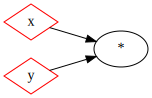

In [1]:
from tuneit import *

x = variable( [1, 2, 3, 4] )
y = variable( [0.1, 1, 10])

visualize( x * y )

With tuneit one can easily construct a computational graph having *variables* as free parameters.

The computation can then be:

- **sampled**: get the value of the computation varying the parameters

- **crosschecked**: check that the computation always gives the same value varying the parameters

- **minimized**: find the parameters which give the minimal value

- **benchmarked**: time the computation varying the parameters

- **tuned**: find the parameters which give the smallest time to solution

## Interface to hyper-parameter tuners (TODO)

The main idea of tuneit is to provide an interface to one or more hyper-parameter tuners in Python.

- [scikit-optimize](https://scikit-optimize.github.io/stable/): offers Bayesian Optimization and visualization tools.

- [hyperopt](https://hyperopt.github.io/hyperopt/): offers Tree-Parzen Estimators and variants.

- [tune (ray-project)](https://docs.ray.io/en/latest/tune.html): interfaces to the two above and many others. Main focus task distribution.

These will be used to efficiently tune the computational parameters.

## Example: vector concatenation

In [1]:
import numpy
import perfplot
from matplotlib import pyplot as plt
perfplot.main.tqdm = lambda iterable, *args, **kwargs: iterable

def double_vector(vec):
    vec2 = numpy.ndarray((len(vec), 2))
    vec2[:,0] = vec
    vec2[:,1] = vec
    return vec2

out = perfplot.bench(
    setup=lambda n: numpy.random.rand(n),
    kernels=[
        double_vector,
        lambda a: numpy.c_[a, a],
        lambda a: numpy.stack([a, a]).T,
        lambda a: numpy.vstack([a, a]).T,
        lambda a: numpy.column_stack([a, a]),
        lambda a: numpy.concatenate([a[:, None], a[:, None]], axis=1),
    ],
    target_time_per_measurement=0.1,
    labels=["double_vector", "c_", "stack", "vstack", "column_stack", "concat"],
    n_range=[2 ** k for k in range(18)],
    xlabel="Vector size",
)

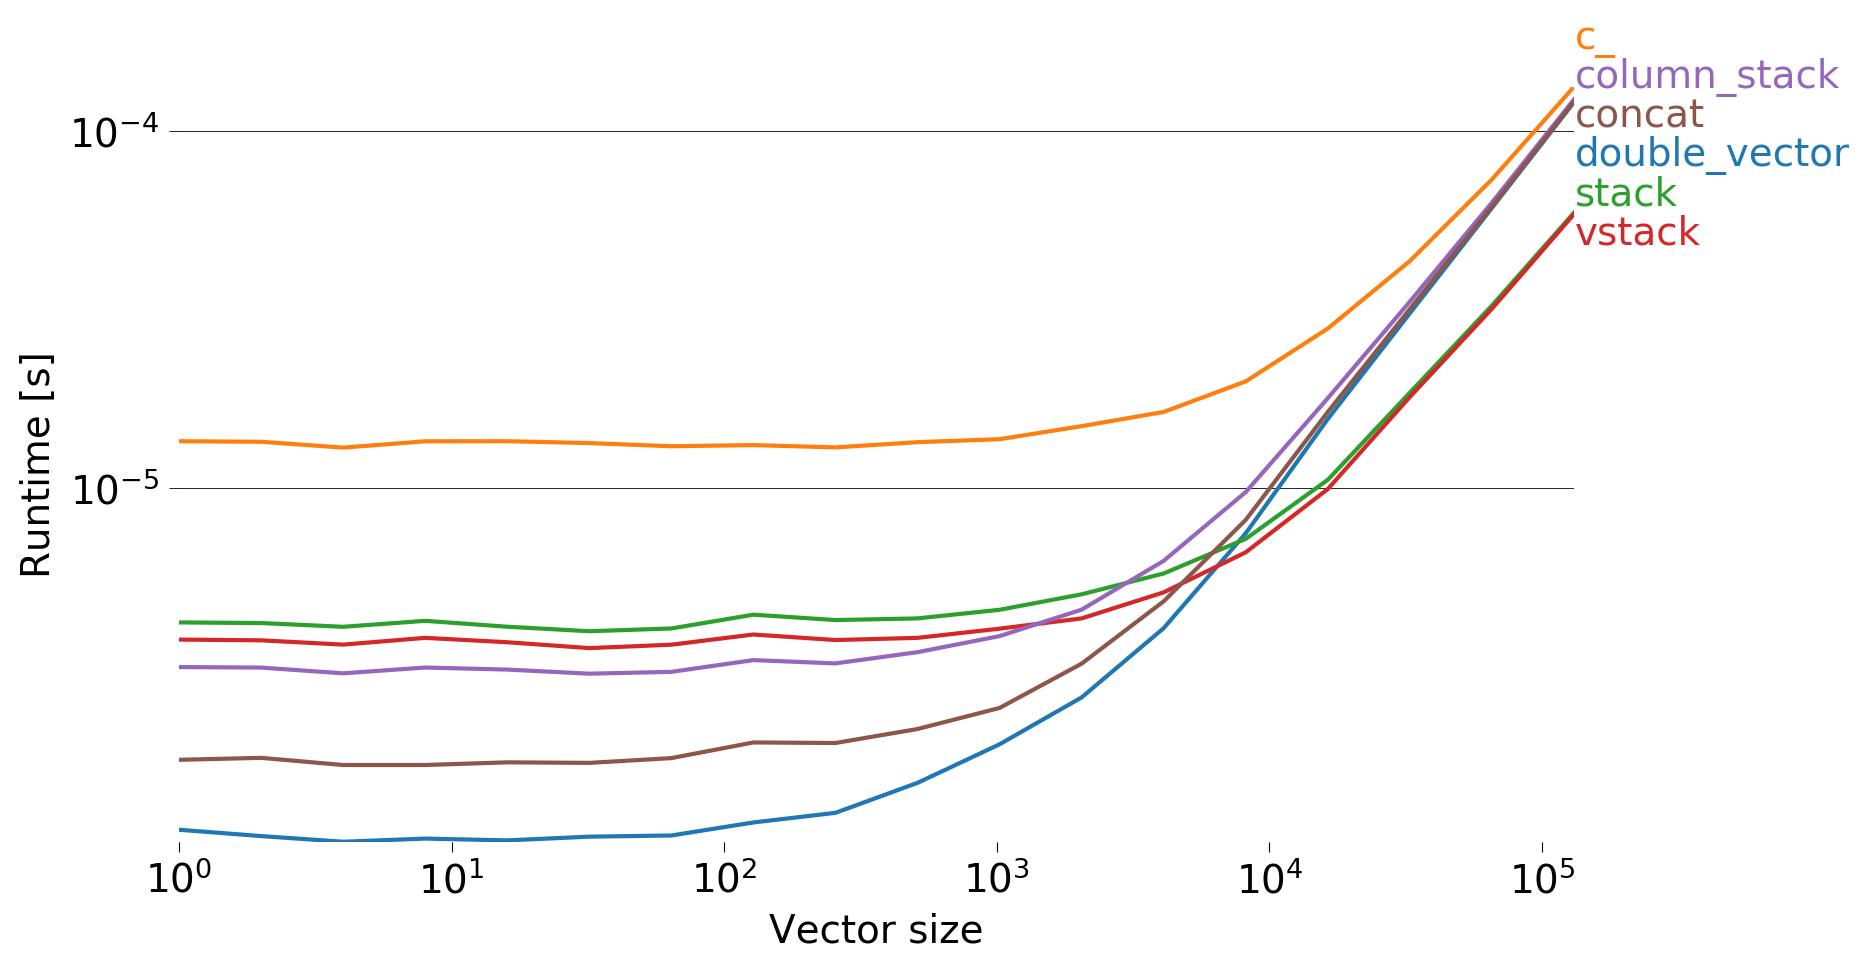

In [3]:
fig = plt.figure(figsize=(9, 5), dpi= 200, facecolor='w', edgecolor='k')
plt.rcParams['text.color']='black'
plt.rcParams['axes.labelcolor']='black'
plt.rcParams['xtick.color']='black'
plt.rcParams['ytick.color']='black'
plt.rcParams['grid.color']='black'
out.show()

In [2]:
import numpy

@alternatives(
    c_ = lambda a: numpy.c_[a, a],
    stack = lambda a: numpy.stack([a, a]).T,
    vstack = lambda a: numpy.vstack([a, a]).T,
    column_stack = lambda a: numpy.column_stack([a, a]),
    concatenate = lambda a: numpy.concatenate([a[:, None], a[:, None]], axis=1),
)
def double_vector(vec):
    vec2 = numpy.ndarray((len(vec), 2))
    vec2[:,0] = vec
    vec2[:,1] = vec
    return vec2

vec = double_vector(numpy.random.rand(100))
vec

Tunable(double_vector-7b3cb3897126e1da4b3056bf255cea07)

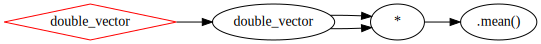

In [3]:
norm2 = (vec * vec).mean()
visualize(norm2)

In [4]:
crosscheck(vec)

double_vector,xcheck
c_,True
stack,True
vstack,True
column_stack,True
concatenate,True
double_vector,True


In [6]:
benchmark(vec)

double_vector,Time
c_,109.090 usec
stack,59.424 usec
vstack,51.173 usec
column_stack,47.474 usec
concatenate,44.927 usec
double_vector,42.468 usec


# Field operations in Lyncs

- **Axes** are the key components of a field, they determine the size, properties and are required in axes-wise operations

- Field operations are always performed in a **lazy** manner and a *tunable* computational graph is constructed

- Validity **checks** are performed during the construction of the graph for being sure that is possible to execute it

- The computational graph can be optimized, **tuned**, submitted for parallel execution, etc...

- The class keeps **track** of all the structural changes and the field's structure is always known

- The operations rely on the implementation on **backends** e.g. `numpy`, `cuPy` (for GPU) or `dask.Array` (for distributed)

## Structural changes

- `.reorder`, changes the order of axes

- `.reorder_label`, changes the order of labels within a label axis

- `.reshape`, adds (`.extend`) or removes (`.squeeze`) axes

- `.map`, applies a map between lattices

- `.rechunk`, changes the partitioning of the field

- `.transfer`, changes the owner(s) of the field

- `.astype`, changes the data type of the field


### Example

In [17]:
field = lattice.Vector()
field.shape

(('t_0', 8), ('x_0', 4), ('y_0', 4), ('z_0', 4), ('spin_0', 4), ('color_0', 3))

In [18]:
ordered_field = field.reorder(field.indeces)
ordered_field.indeces_order

Permutation(('t_0', 'x_0', 'y_0', 'z_0', 'spin_0', 'color_0'), value=('t_0', 'x_0', 'y_0', 'z_0', 'spin_0', 'color_0'))

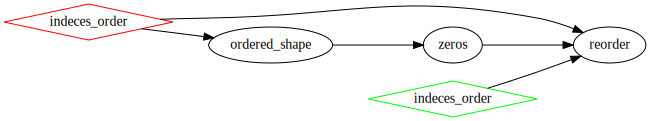

In [19]:
ordered_field.visualize()

In [20]:
ordered_field.ordered_shape

(8, 4, 4, 4, 4, 3)

## Element access

In [21]:
lattice.coords

{'origin': {'t': 0, 'x': 0, 'y': 0, 'z': 0},
 'source': {'t': 0, 'x': 2, 'y': 1, 'z': 2}}

In [40]:
field.shape

(('t_0', 8), ('x_0', 4), ('y_0', 4), ('z_0', 4), ('spin_0', 4), ('color_0', 3))

In [37]:
field2 = field["origin"]
field2.coords

{'t_0': 0, 'x_0': 0, 'y_0': 0, 'z_0': 0}

In [38]:
field3 = field2.get(spin_0 = (0,2), color_0 = slice(None))
field3.coords

{'spin_0': (0, 2), 't_0': 0, 'x_0': 0, 'y_0': 0, 'z_0': 0}

In [39]:
field3.shape

(('t_0', 1), ('x_0', 1), ('y_0', 1), ('z_0', 1), ('spin_0', 2), ('color_0', 3))

## Contractions

User-friendly contractions are performed with the`dot` function that uses the `einsum` function.

`dot(*fields, closed_indices=[...], open_indices=[...], trace=?)`

In [3]:
colors = lattice.Field(axes = ["color","color"])
colors.dot(colors, debug = True)

({'color_0': 0, 'color_1': 1},
 {'color_0': 1, 'color_1': 2},
 {'color_0': 0, 'color_1': 2})

In [57]:
colors.dot(colors, trace=True, debug=True)

({'color_0': 0, 'color_1': 1}, {'color_0': 1, 'color_1': 0}, {})

In [58]:
colors.dot(colors, open_indeces=["color"], debug=True)

({'color_0': 0, 'color_1': 1},
 {'color_0': 2, 'color_1': 3},
 {'color_0': 0, 'color_1': 1, 'color_2': 2, 'color_3': 3})

## Reductions and other functions

Based on numpy, many other functions are available, e.g.

- reductions: `mean`, `sum`, `std`, `min`, `max`, ...

- math operations: `sin`, `cos`, `pow`, ...

- random numbers: `uniform`, `normal`, ...

**Note**: axes labels are used anywhere axes is expected by numpy, e.g. `mean("space")`

**Note**: reproducible random numbers are available at additional costs

# Conclusions

Next features to be implemented

- New Dask interface

- Support for sparse fields (also in connection with libRSB)

- Support for GPU arrays (via cuPy)

- Support for a large variety of IO

Things to discuss

- How to implement operators / field transformations

- Support shifted fields instead of rolling